In [1]:
from torch import nn, optim
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
#Network architecture
'''class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        #20% probability Dropout 
        self.dropout = nn.Dropout(p=.2)

    def forward(self, x):
        #flatten input tensor
        x = x.view(x.shape[0], -1)

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        return x'''
                        
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6,16, 5, padding=0)

        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.pool = nn.AvgPool2d(2, 2)

    def forward(self, x):

        x = F.sigmoid(self.conv1(x))
        x = self.pool(x)
        
        x = F.sigmoid(self.conv2(x))
        x = self.pool(x)
        
        x = x.view(x.shape[0], -1)
        
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        
        return x  

In [30]:
from torchsummary import summary

model = Classifier()
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


In [3]:
transform = transforms.ToTensor()

#Download and load training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/',download=True,train=True,transform=transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=64,shuffle=True)

#Download and load test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/',download=True,train=False,transform=transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)

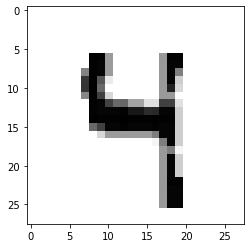

In [32]:
image, label = next(iter(trainLoader))
plt.imshow(image[0,:].reshape(28,28),cmap='binary')

In [11]:
model = Classifier()
#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 10#30
steps = 0
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for imgs, labels, in trainLoader:
        logps = model(imgs)
        loss = criterion(logps, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss}")
        
        test_loss = 0
        acc = 0
        #Disable gradients for validation
        with torch.no_grad():
            #set model to evaluation mode (w/o dropout)
            model.eval()

            for imgs, labels in testLoader:
                log_ps = model(imgs)
                test_loss += criterion(log_ps, labels)
                #class probability
                ps = torch.exp(log_ps)
                #most likely classes
                top_p, top_class = ps.topk(1, dim=1)
                #check if top classes matches with the labels
                equals = top_class == labels.view(*top_class.shape)
                #convert 'equals' to a float tensor
                acc += torch.mean(equals.type(torch.FloatTensor))

        train_losses.append(running_loss/len(trainLoader))
        test_losses.append(test_loss/len(testLoader))
        print("Epoch: {}/{}.. ".format(e+1,epochs),
                "Training Loss: {:.3f}.. ".format(running_loss/len(trainLoader)),
                "Test Loss: {:.3f}.. ".format(test_loss/len(testLoader)),
                "Test Acc: {:.3f}.. ".format(acc/len(testLoader)))

        #set model back to train mode
        model.train()

Training loss: 699.5331731140614
Epoch: 1/10..  Training Loss: 0.746..  Test Loss: 0.199..  Test Acc: 0.938.. 
Training loss: 138.27781897969544
Epoch: 2/10..  Training Loss: 0.147..  Test Loss: 0.105..  Test Acc: 0.970.. 
Training loss: 87.45551963755861
Epoch: 3/10..  Training Loss: 0.093..  Test Loss: 0.072..  Test Acc: 0.979.. 
Training loss: 67.80541055789217
Epoch: 4/10..  Training Loss: 0.072..  Test Loss: 0.062..  Test Acc: 0.982.. 
Training loss: 55.42793013621122
Epoch: 5/10..  Training Loss: 0.059..  Test Loss: 0.064..  Test Acc: 0.980.. 
Training loss: 45.503746823058464
Epoch: 6/10..  Training Loss: 0.049..  Test Loss: 0.047..  Test Acc: 0.984.. 
Training loss: 40.4586915448308
Epoch: 7/10..  Training Loss: 0.043..  Test Loss: 0.050..  Test Acc: 0.984.. 
Training loss: 35.74117037106771
Epoch: 8/10..  Training Loss: 0.038..  Test Loss: 0.044..  Test Acc: 0.986.. 
Training loss: 31.99353339278605
Epoch: 9/10..  Training Loss: 0.034..  Test Loss: 0.038..  Test Acc: 0.988.. 


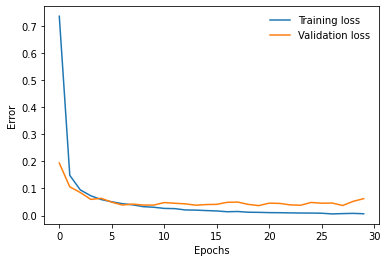

In [34]:
#Plot Train and Validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

In [51]:
import numpy as np

In [54]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

torch.Size([16, 6, 5, 5])


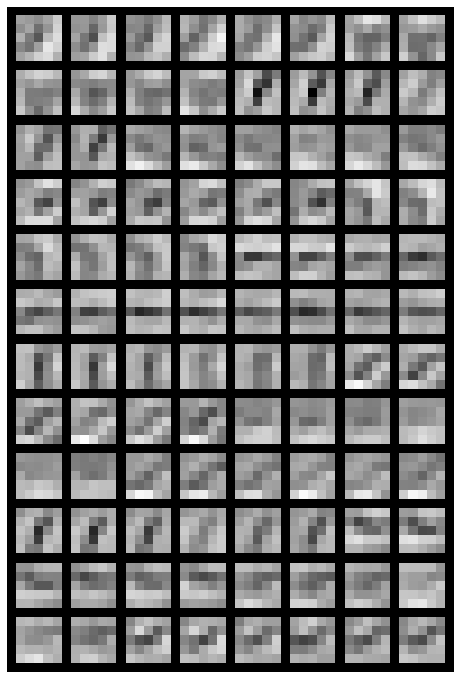

In [67]:
filtr = model.conv2.weight.clone()
print(filtr.shape)
visTensor(filtr, ch=0, allkernels=True)

plt.axis('off')
plt.ioff()
plt.show()

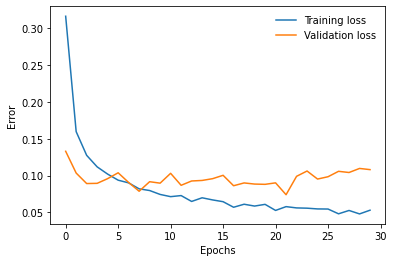

In [7]:
#Plot Train and Validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.show()

In [8]:
#Save model to file
torch.save(model.state_dict(), 'checkpoint.pth')
print("Model:' \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Model:' 

 Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])
